# 1. Importing libraries

In [61]:
import statistics
import pandas as pd
from random import sample
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

# 2.Loading the dataset and cleaning

In [19]:
archive = zipfile.ZipFile('marketing_AB.csv.zip', 'r')
df = pd.read_csv(archive.open('marketing_AB.csv')).iloc[:, 1:]

In [20]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# 3. Data characteristics

Variables:
- user_id: unique customer identifier
- test_group: control (psa) are ones who saw public service announcement, experimental (ads) are the ones who saw the ad
- converted: False - did not buy the product, True - bought the product
- total_ads: the number of ads seen by the customer
- most_ads_day: the day of the week the customer saw the most ads 
- most_ads_hour: the hour of the day the customer saw the most ads 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


Results: 
- Sample size is 588101
- There are no missing values.

In [26]:
# Next we will need to look at two groups: control and experimental
df.test_group.value_counts()

test_group
ad     564577
psa     23524
Name: count, dtype: int64

In [45]:
# Need to look at the number of people who bought the product based on their test group
df.groupby("test_group")["converted"].value_counts().reset_index()

,test_group,converted,count
0,ad,False,550154
1,ad,True,14423
2,psa,False,23104
3,psa,True,420


In [59]:
conv_rate_control= round(df[df.test_group=="psa"]["converted"].mean()*100,3)
conv_rate_ex= round(df[df.test_group=="ad"]["converted"].mean()*100,3)
print(" The conversion rate of control group is",conv_rate_control,"%") 
print(" The conversion rate of experimental group is",conv_rate_ex,"%") 

 The conversion rate of control group is 1.785 %
 The conversion rate of experimental group is 2.555 %


Results:
- From the conversion rates we can see that the ad seems to lead to higher conversion rate. The difference between groups is 0.77% 
- However, we can see that the sample size of the experimental group is much bigger than the size of the control group. The imbalanced sampling might introduce bias since the sample mean that is used to compare the groups is heavily influenced by the sample size. If one group has a small sample size the sample mean might not be a representative of the true mean of the population.
- To deal with imbalanced samples, we can use resampling technique such as bootstratpping with replacement.

# 4.Bootstrapping

In [60]:
# create two dataframes for experimental and control groups

df_ex=df[df.test_group=="ad"]
df_control=df[df.test_group=="psa"]

I will use resampling with replacement, which means that the dataframe might have duplicates, which is similar to real-world random sampling from population. There will be 1000 bootstrap samples and after each iteration sample mean will be calculated. The sample size of bootstrap sample should be the same as in the original sample

In [65]:
# creating an empty list to store sample means for experimental group

mean_ex= []

# create a loop to resample and calculate sample means 1000 times


for i in range (1000):
    sample_mean=df_ex.sample(frac=1, replace=True)["converted"].mean()
    mean_ex.append(sample_mean)

df_mean_ex=pd.DataFrame(mean_ex)

In [74]:
# creating an empty list to store sample means for experimental group

mean_control= []

# create a loop to resample and calculate sample means 1000 times


for i in range (1000):
    sample_mean=df_control.sample(frac=1, replace=True)["converted"].mean()
    mean_control.append(sample_mean)

df_mean_control=pd.DataFrame(mean_control)

<Axes: ylabel='Density'>

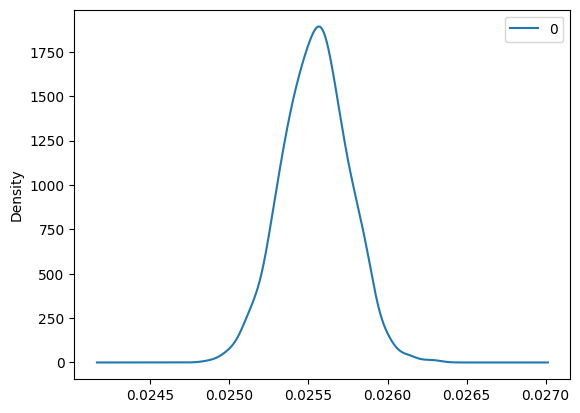

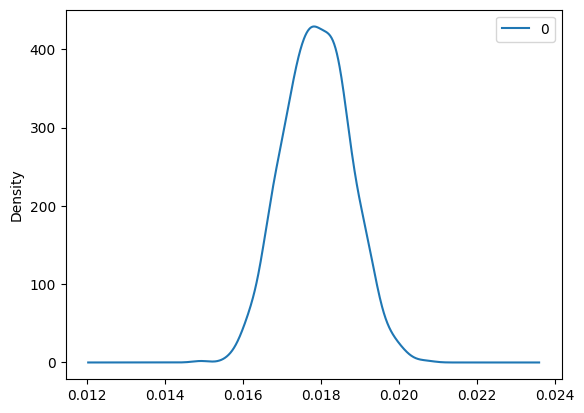

In [78]:
df_mean_ex.plot(kind="density")
df_mean_control.plot(kind="density")

The distribution of two bootstrapped samples is approximately normal, which satisfies the assumption of normality and allows to conduct hypothesis testing.

# 5. Hypothesis testing

Research question: Do ads improve conversion rate? 

- Null hypothesis: The sample mean of experimental group is less or equal to the sample mean of control group 
- Alternative hypothesis: The sample mean of experimental group is greater than the sample mean of control group

<Axes: ylabel='Density'>

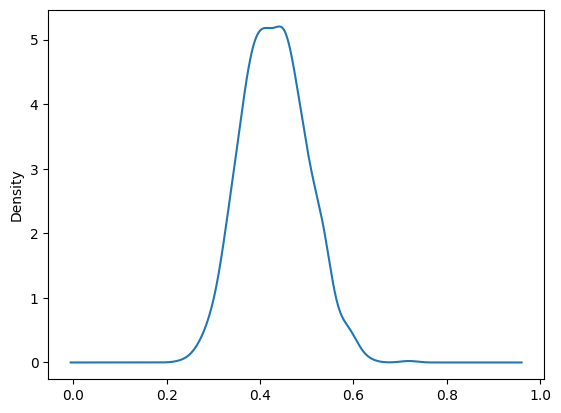

In [83]:
### we need to look at the distribution of the difference between two groups
df_mean_ex.columns=["conv_ex"]
df_mean_control.columns=["conv_control"]

df_comb_mean=pd.concat([df_mean_ex, df_mean_control], axis=1)
df_comb_mean["diff"]= (df_comb_mean["conv_ex"]-df_comb_mean["conv_control"])/df_comb_mean["conv_control"]

df_comb_mean["diff"].plot(kind="density")

The difference between control and experimental group is approximately normal, so we can use parametric test. We can use z-test since the sample size is quite large even though the population variance is unknown 

In [131]:
boot_ad_converted=df_comb_mean['conv_ex']
boot_psa_converted=df_comb_mean['conv_control']

boot_ad_mean=boot_ad_converted.mean()
boot_psa_mean=boot_psa_converted.mean()
boot_ad_std=boot_ad_converted.std()
boot_psa_std=boot_psa_converted.std()

pooled_std=np.sqrt((boot_ad_std**2+boot_psa_std**2)/2)
z_score=(boot_ad_mean-boot_psa_mean)/pooled_std
p_value=1-stats.norm.cdf(z_score)

print('z score',z_score)
print('P Value',p_value)


z score 12.406045496199052
P Value 0.0


The results:
- the p value is 0, this means that we reject null hypothesis. This means that that the conversion rate of ad group is significantly greater than the conversion rate of psa group.